In [134]:
import os

import numpy as np
import fitsio
import matplotlib.pyplot as plt

from speclite import filters
from astropy import constants
import astropy.units as u
from desisim.io import read_basis_templates

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [76]:
sweepfile = 'sweep-240p000-250p005.fits'
print('Reading {}'.format(sweepfile))
allcat = fitsio.read(sweepfile, ext=1, upper=True)

Reading sweep-240p000-250p005.fits


In [77]:
# Correct for reddening 
allcat['DECAM_FLUX'] = allcat['DECAM_FLUX'] / allcat['DECAM_MW_TRANSMISSION'] 
allcat['WISE_FLUX'] = allcat['WISE_FLUX'] / allcat['WISE_MW_TRANSMISSION'] 
allcat['DECAM_FLUX_IVAR'] = allcat['DECAM_FLUX_IVAR'] * allcat['DECAM_MW_TRANSMISSION']**2
allcat['WISE_FLUX_IVAR'] = allcat['WISE_FLUX_IVAR'] * allcat['WISE_MW_TRANSMISSION']**2

In [78]:
# Cut on magnitude
magcut = 19.5
these = np.where( allcat['DECAM_FLUX'][..., 2] > 1e9 * 10**(-0.4*magcut) )[0]
cat = allcat[these]

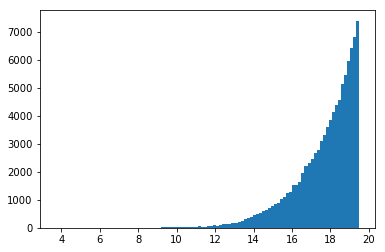

In [82]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(22.5 - 2.5*np.log10(allcat['DECAM_FLUX'][..., 2][these]), bins=100)

In [6]:
filts = ('decam2014-g', 'decam2014-r', 'decam2014-z', 'wise2010-W1', 'wise2010-W2')
filt = filters.load_filters(*filts)

In [117]:
flux, wave, meta = read_basis_templates(objtype='STAR')
nt = len(meta)
print('Number of templates = {}'.format(nt))

INFO:io.py:625:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits
Number of templates = 931


In [84]:
flux.shape

(931, 118466)

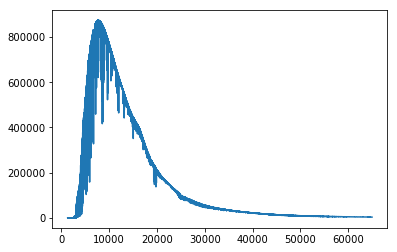

In [126]:
plt.plot(wave, flux[100, :])

In [85]:
phot = filt.get_ab_maggies(flux, wave, mask_invalid=False)
synthflux = np.vstack( [phot[ff].data for ff in filts] )

In [86]:
cc = dict(
    gr = -2.5 * np.log10(synthflux[0, :] / synthflux[1, :]),
    rz = -2.5 * np.log10(synthflux[1, :] / synthflux[2, :]),
    rW1 = -2.5 * np.log10(synthflux[1, :] / synthflux[3, :]),
    zW1 = -2.5 * np.log10(synthflux[2, :] / synthflux[3, :]),
)

In [87]:
obsflux = np.vstack( ([cat['DECAM_FLUX'][:, bb] for bb in (1, 2, 4)] +  
                      [cat['WISE_FLUX'][:, bb] for bb in (0, 1)]) )
obsivar = np.vstack( ([cat['DECAM_FLUX_IVAR'][:, bb] for bb in (1, 2, 4)] + 
                      [cat['WISE_FLUX_IVAR'][:, bb] for bb in (0, 1)]) )

In [88]:
obsflux.shape, obsivar.shape, synthflux.shape

((5, 96818), (5, 96818), (5, 931))

In [89]:
# Get the chi2 normalization factor
scale = ( 
    np.sum(obsivar[:, :, np.newaxis] * obsflux[:, :, np.newaxis] *\
           synthflux[:, np.newaxis, :], axis=0) ) / (
    np.sum(obsivar[:, :, np.newaxis] * synthflux[:, np.newaxis, :]**2, axis=0)
)

In [90]:
scale.shape

(96818, 931)

In [91]:
# Compute chi2
chi2grid = np.sum(obsivar[:, :, np.newaxis] * (
    obsflux[:, :, np.newaxis] - scale[np.newaxis, :, :] * 
    synthflux[:, np.newaxis, :])**2, axis=0)

In [92]:
chi2grid.shape

(96818, 931)

In [38]:
if False:
    ss = ( np.sum(obsivar[:, 100] * obsflux[:, 100] * synthflux[:, 500], axis=0) ) / (
        np.sum(obsivar[:, 100] * synthflux[:, 500]**2, axis=0) )
    csq = np.sum(obsivar[:, 100] * (obsflux[:, 100] - ss * synthflux[:, 500])**2)
    print(csq, chi2grid[100, 500])

In [93]:
chi2min, mindx = np.min(chi2grid, axis=1), np.argmin(chi2grid, axis=1)
print(chi2min.shape, mindx.shape)

(96818,) (96818,)


In [103]:
# Pick one example object
this = 500

(293, 393)

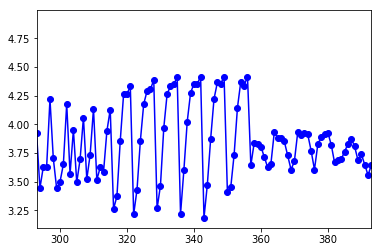

In [104]:
plt.plot(np.log10(chi2grid[this, :]), '-bo')
plt.xlim(mindx[this]-50, mindx[this]+50)

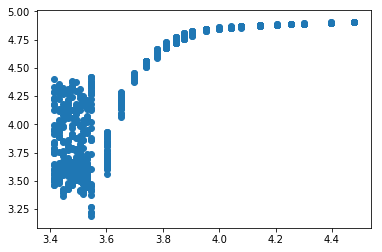

In [107]:
plt.scatter(np.log10(meta['TEFF']), np.log10(chi2grid[this, :]))

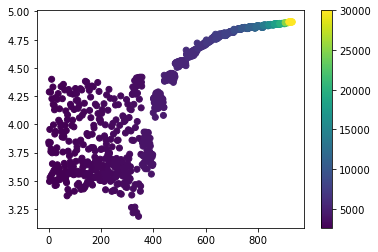

In [108]:
plt.scatter(np.arange(nt), np.log10(chi2grid[this, :]), c=meta['TEFF'])
plt.colorbar()

In [145]:
def flam2fnu(wave, flux, scale=1.0, ABmag=False):
    light = constants.c.to('AA/s').value
    fnu = scale * flux * wave**2 / light 
    if ABmag:
        fnu = -2.5 * np.log10(fnu) - 48.6
    else:
        fnu = fnu * 10**(0.4*48.6)
    return fnu

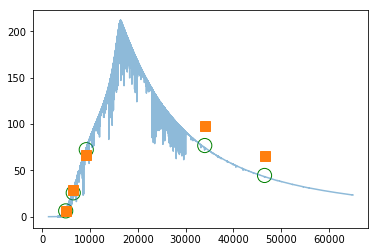

In [162]:
fig, ax = plt.subplots()
ax.plot(wave, flam2fnu(wave, flux[mindx[this], :], scale=scale[this, mindx[this]]), 
        alpha=0.5)
ax.errorbar(filt.effective_wavelengths.value, obsflux[:, this], xerr=0.0, 
            yerr=1.0 / np.sqrt(obsivar[:, this]), fmt='s', 
            markersize=10)
ax.scatter(filt.effective_wavelengths, scale[this, mindx[this]] * synthflux[:, mindx[this]], 
           s=200, color='green', facecolor='none')
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(2500, 6e4)

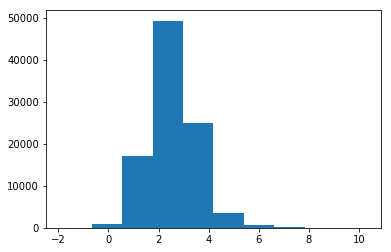

In [164]:
_, _, _ = plt.hist(np.log10(chi2min))

In [165]:
istar = chi2min < 30
np.sum(istar)

10205

In [166]:
grrange = (-0.5, 2.5)
rzrange = (-0.5, 2)
rW1range = (-2, 5)
mzrange = (17.5, 20.5)

In [167]:
def flux2colors(cat):
    """Convert DECam/WISE fluxes to magnitudes and colors."""
    colors = dict()
    with warnings.catch_warnings(): # ignore missing fluxes (e.g., for QSOs)
        warnings.simplefilter('ignore')
        for ii, band in zip((1, 2, 4), ('g', 'r', 'z')):
            colors[band] = 22.5 - 2.5 * np.log10(cat['DECAM_FLUX'][..., ii].data)
        for ii, band in zip((0, 1), ('W1', 'W2')):
            colors[band] = 22.5 - 2.5 * np.log10(cat['WISE_FLUX'][..., ii].data)
    colors['gr'] = colors['g'] - colors['r']
    colors['rz'] = colors['r'] - colors['z']
    colors['rW1'] = colors['r'] - colors['W1']
    colors['W1W2'] = colors['W1'] - colors['W2']

    return colors

In [168]:
data = flux2colors(cat)

In [169]:
def grz(models=False, pngfile=None):
    fig, ax = plt.subplots()
    #hb = ax.hexbin(data['rz'], data['gr'], bins='log', cmap='Blues_r', 
    #               mincnt=2, extent=rzrange+grrange)
    hb = ax.scatter(data['rz'], data['gr'], c=np.log10(chi2min), s=1, edgecolor='none')
    ax.scatter(data['rz'][istar], data['gr'][istar], s=5, color='orange', marker='s')
    ax.set_xlabel('r - z')
    ax.set_ylabel('g - r')
    ax.set_xlim(rzrange)
    ax.set_ylim(grrange)
    cb = fig.colorbar(hb, ax=ax)
    #cb.set_label(r'log$_{10}$ (Number of Galaxies per Bin)')
    if models:
        ax.scatter(cc['rz'], cc['gr'], marker='o', facecolors='none', 
                   s=50, edgecolors='k', linewidth=1)
    if pngfile:
        fig.savefig(pngfile)

In [170]:
def rzW1(models=False, pngfile=None):
    fig, ax = plt.subplots()
    #hb = ax.hexbin(data['rz'], data['rW1'], bins='log', cmap='Blues_r', 
    #               mincnt=1, extent=rzrange+grrange)
    hb = ax.scatter(data['rz'], data['rW1'], c=np.log10(chi2min), s=1, edgecolor='none')
    ax.scatter(data['rz'][istar], data['rW1'][istar], s=5, color='orange', marker='s')
    ax.set_xlabel('r - z')
    ax.set_ylabel('r - W1')
    ax.set_xlim(rzrange)
    ax.set_ylim(rW1range)
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label(r'log$_{10}$ (Number of Galaxies per Bin)')
    if models:
        ax.scatter(cc['rz'], cc['rW1'], marker='o', facecolors='none', 
                   s=10, edgecolors='k', linewidth=1)
    if pngfile:
        fig.savefig(pngfile)

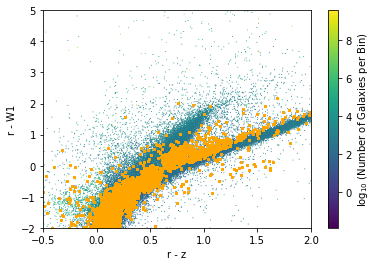

In [171]:
rzW1()

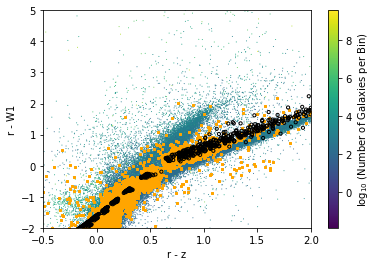

In [172]:
rzW1(models=True)

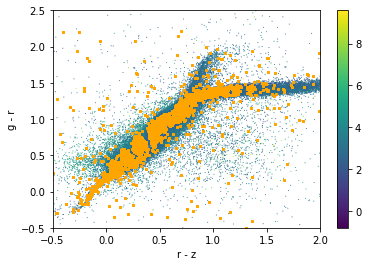

In [173]:
grz()

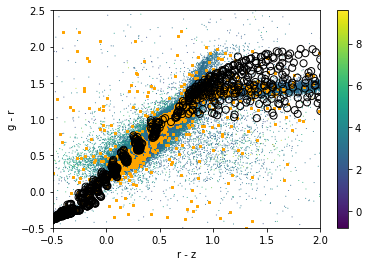

In [174]:
grz(models=True)